In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from enum import Enum

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector



class StateOfTree(Enum):
    HEALTHY = 0
    BURNING = 1 
    DEAD = 2

    
class ForestFire(Model):


    def __init__(self, height=20, width=20, density=0.9, seed=None):
        self.scheduler = RandomActivation(self)
        self.space = SingleGrid(height, width, torus=False)
        
        for i, (_, x, y) in enumerate(self.space.coord_iter()):
            if self.random.random() < density:
                # Create a tree
                tree = Tree(i, (x, y), self)

                self.space._place_agent((x, y), tree)
                self.scheduler.add(tree)        

                
    def step(self):
        """
        Run one step of the model.
        """
        self.scheduler.step()


class Tree(Agent):


    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos
        self.status = StateOfTree.HEALTHY
        
    def step(self):
        if self.status == StateOfTree.BURNING:
            for neighbor in self.model.space.neighbor_iter(self.pos, moore=False):
                if neighbor.status == StateOfTree.HEALTHY:
                    neighbor.status = StateOfTree.BURNING
            # implicit assumption of 1 tick for burning down
            self.status = StateOfTree.DEAD


def plot_model(model):
    sns.set_style('white')
    fig, ax = plt.subplots()
    palette = sns.color_palette()
    colors = [palette[i] for i in [2, 3, 5, 7]]

    grid = np.zeros((model.space.height, model.space.width, 3))
    
    for i, row in enumerate(model.space.grid):
        for j, cell in enumerate(row):
            if cell:
                color = colors[cell.status.value]
            else:
                color = colors[3]
            grid[i,j, :] = color
    ax.imshow(grid)
    ax.set_xticks([])
    ax.set_yticks([])
    return fig
    
    

In [2]:
model = ForestFire(100, 100, seed=12345)
model.space[0,0].status = StateOfTree.BURNING
plt.show()

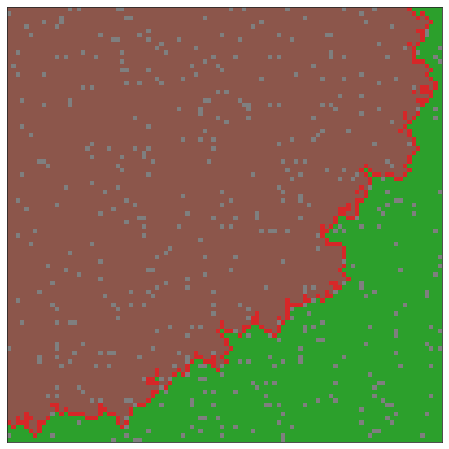

In [3]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, collections
from matplotlib import pyplot as plt
from IPython.display import HTML

model = ForestFire(100, 100, 0.95, seed=12345)
model.space[0,0].status = StateOfTree.BURNING


sns.set_style('white')
fig, ax = plt.subplots()
palette = sns.color_palette()
colors = [palette[i] for i in [2, 3, 5, 7]]

def get_grid(model):
    grid = np.zeros((model.space.height, model.space.width, 3))
    
    for i, row in enumerate(model.space.grid):
        for j, cell in enumerate(row):
            if cell:
                color = colors[cell.status.value]
            else:
                color = colors[3]
            grid[i,j, :] = color
    return grid

grid = get_grid(model)
im = ax.imshow(grid)
ax.set_xticks([])
ax.set_yticks([])


def update(frame):
    model.step()
    
    grid = get_grid(model)
    
    im.set_data(grid)
    # ax.set(title=str(number_of_cars) + " cars on the road, t= " + str(model.scheduler.steps))

    return im

anim = FuncAnimation(fig, update, interval=100, frames=40);
HTML(anim.to_html5_video())  

#writervideo = animation.FFMpegWriter(fps=12,bitrate=900) 
#anim.save("cars.mp4", writer=writervideo,dpi=200)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from enum import Enum

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector



class StateOfTree(Enum):
    HEALTHY = 0
    BURNING = 1 
    DEAD = 2

    
class ForestFire(Model):


    def __init__(self, height=20, width=20, density=0.9, seed=None,
                 moore=False):
        self.scheduler = RandomActivation(self)
        self.space = SingleGrid(height, width, torus=False)
        Tree.moore = moore
        
        for i, (_, x, y) in enumerate(self.space.coord_iter()):
            if self.random.random() < density:
                # Create a tree
                tree = Tree(i, (x, y), self)

                self.space._place_agent((x, y), tree)
                self.scheduler.add(tree)        

                
    def step(self):
        """
        Run one step of the model.
        """
        self.scheduler.step()


class Tree(Agent):
    moore = False
    radius = 1

    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos
        self.status = StateOfTree.HEALTHY
        
    def step(self):
        if self.status == StateOfTree.BURNING:
            # this is needed for controling the radius
            # strangely, model.space.neighborhood_iter does not
            # take a radius argument
            neighborhood = self.model.space.get_neighborhood(self.pos,
                                                 moore=self.moore, radius=self.radius)
            neighborhood_iter = self.model.space.iter_cell_list_contents(neighborhood)            
            
            for neighbor in neighborhood_iter:
                if neighbor.status == StateOfTree.HEALTHY:
                    neighbor.status = StateOfTree.BURNING
            # implicit assumption of 1 tick for burning down
            self.status = StateOfTree.DEAD


def plot_model(model):
    sns.set_style('white')
    fig, ax = plt.subplots()
    palette = sns.color_palette()
    colors = [palette[i] for i in [2, 3, 5, 7]]

    grid = np.zeros((model.space.height, model.space.width, 3))
    
    for i, row in enumerate(model.space.grid):
        for j, cell in enumerate(row):
            if cell:
                color = colors[cell.status.value]
            else:
                color = colors[3]
            grid[i,j, :] = color
    ax.imshow(grid)
    ax.set_xticks([])
    ax.set_yticks([])
    return fig
    
    

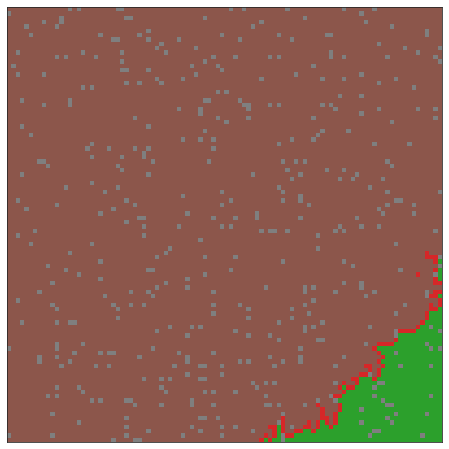

In [17]:
model = ForestFire(100, 100, 0.95, seed=12345)
model.space[0,0].status = StateOfTree.BURNING

for _ in range(50):
    model.step()
    
plot_model(model)
plt.show()

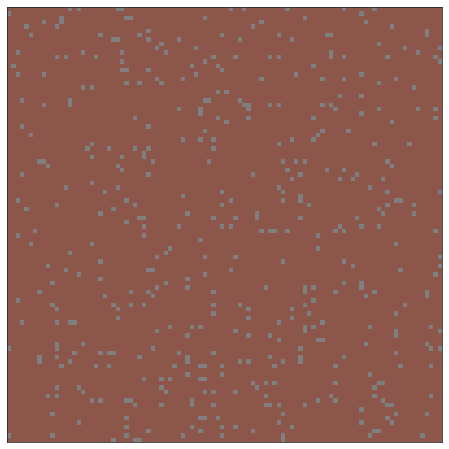

In [18]:
model = ForestFire(100, 100, 0.95, seed=12345, moore=True)
model.space[0,0].status = StateOfTree.BURNING

for _ in range(50):
    model.step()
    
plot_model(model)
plt.show()

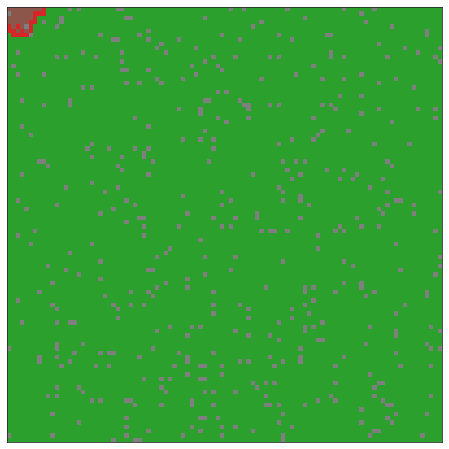

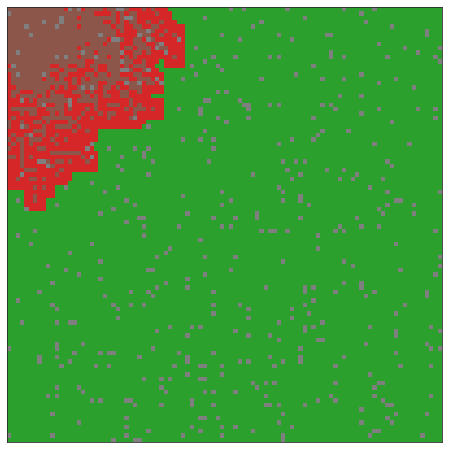

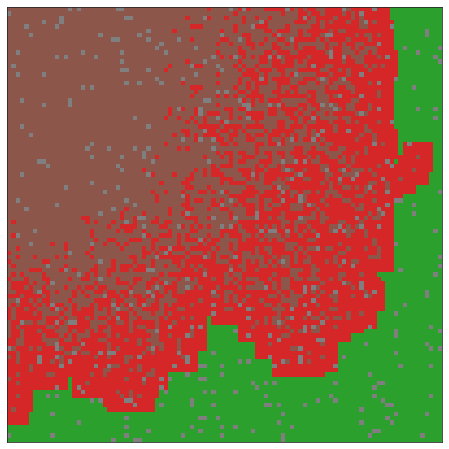

In [24]:

for i in range(1, 4):
    Tree.radius = i
    model = ForestFire(100, 100, 0.95, seed=12345, moore=True)
    model.space[0,0].status = StateOfTree.BURNING

    for _ in range(2):
        model.step()

    plot_model(model)
    plt.show()    